In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai import *


Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'



Mounted at /content/gdrive


In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path=Path('/content/gdrive/My Drive/fastai-v3/camvid/camvid/')

In [5]:
path

PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid')

In [13]:
path = untar_data(URLs.CAMVID,dest = path)

In [6]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/codes.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/valid.txt'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/images')]

In [7]:
path_img = path/'images'
path_lbl = path/'labels'


In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/Seq05VD_f02220_P.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/Seq05VD_f02610_P.png'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/camvid/camvid/labels/Seq05VD_f03720_P.png')]

In [8]:
fnames = get_image_files(path_img)

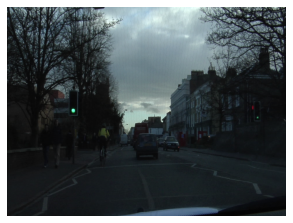

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

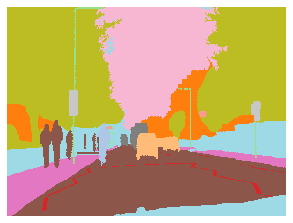

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [13]:
mask.shape

torch.Size([1, 720, 960])

In [14]:
mask.data[0]

tensor([[26, 26, 26,  ..., 26, 26, 26],
        [26, 26, 26,  ..., 26, 26, 26],
        [26, 26, 26,  ..., 26, 26, 26],
        ...,
        [19, 19, 19,  ..., 30, 30, 30],
        [19, 19, 19,  ..., 30, 30, 30],
        [19, 19, 19,  ..., 30, 30, 30]])

In [15]:
codes = np.loadtxt(path/'codes.txt',dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [16]:
src_size = np.array(mask.shape[1:]);
src_size

array([720, 960])

In [25]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")

using bs=8, have 11430 MB of GPU RAM free


In [17]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file(path/'valid.txt')
      .label_from_func(get_y_fn, classes = codes)
      )

In [27]:
data = (src.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

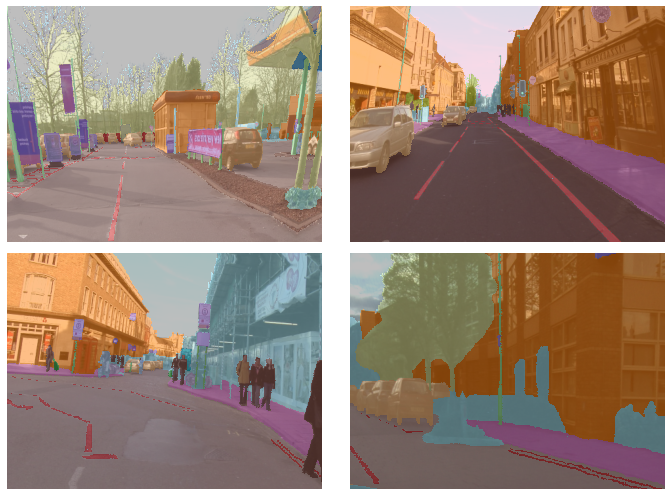

In [75]:
data.show_batch(3,figsize=(10,7))

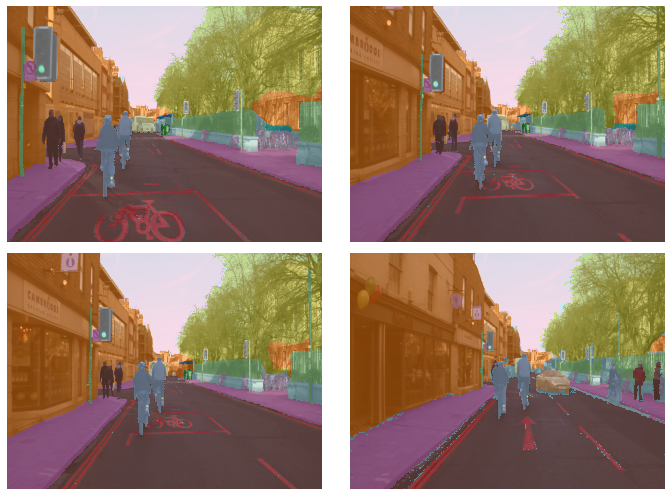

In [76]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [28]:
name2id = {n:i for i,n in enumerate(codes)}

In [29]:
void_code = name2id['Void']
# We hae to remove this void_code while calculating the accuracy

In [30]:
def acc_camvid(input, target):
  target=target.squeeze(1)
  mask = target!=void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()



In [31]:
metrics = acc_camvid

In [22]:
wd = 1e-2

In [23]:
learn = unet_learner(data,arch=models.resnet34,metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


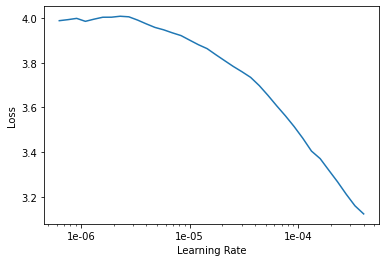

In [25]:
learn.recorder.plot()

In [90]:
learn.fit_one_cycle(8,slice(1e-4))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.608732,1.071532,0.794563,05:00
1,0.854389,0.716986,0.821911,03:45
2,0.688879,0.544782,0.855322,03:44
3,0.606220,0.488899,0.860613,03:44
4,0.523085,0.453062,0.865537,03:44
5,0.489467,0.395915,0.881945,03:44
6,0.438966,0.382492,0.885933,03:43
7,0.423664,0.380800,0.886332,03:44


In [91]:
learn.save('camvid-stage1-34')

In [92]:
learn.unfreeze()

In [93]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


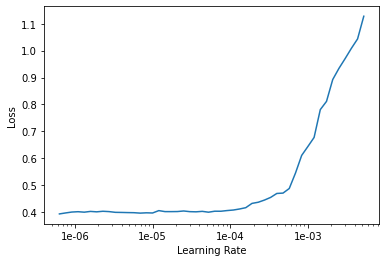

In [94]:
learn.recorder.plot()

In [95]:
learn.fit_one_cycle(10,slice(1e-5,1e-4/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.417769,0.382948,0.884635,03:56
1,0.416897,0.374523,0.885989,03:55
2,0.409727,0.391752,0.881621,03:55
3,0.384872,0.356541,0.894322,03:55
4,0.374788,0.344708,0.898960,03:55
5,0.360393,0.338445,0.900717,03:55
6,0.346695,0.337881,0.899309,03:55
7,0.337090,0.333896,0.900673,03:55
8,0.332185,0.336679,0.900279,03:55
9,0.326041,0.328451,0.902965,03:55


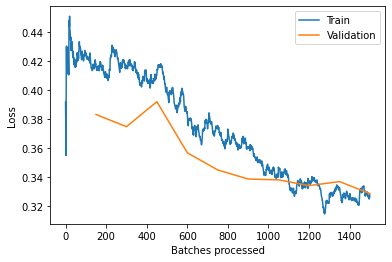

In [96]:
learn.recorder.plot_losses()

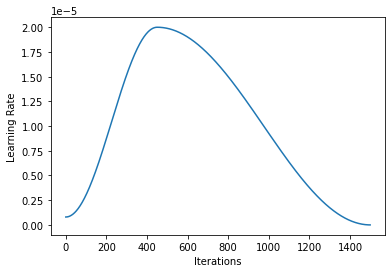

In [97]:
learn.recorder.plot_lr()

In [98]:
learn.save('camvid-stage2-34')

## Now we will increase the size of images - double it and retrain the model on the previously saved weights.


In [18]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8 
else:           bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")

using bs=8, have 11430 MB of GPU RAM free


In [19]:
torch.cuda.empty_cache()

In [34]:
learn.destroy()

NameError: ignored

In [20]:
data = (src.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics).to_fp16()

In [22]:
learn.load('camvid-stage2-34')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /content/gdrive/My Drive/fastai-v3/camvid/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /content/gdrive/My Drive/fastai-v3/camvid/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,fastai.metrics,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


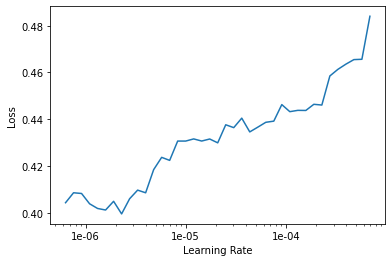

In [24]:
learn.recorder.plot()